<a href="https://colab.research.google.com/github/Svetorus/Insurance/blob/master/Les_3_insur_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### * Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся частях набора данных freMPL(1 и 2).

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    # print(reference)
    return series.astype(np.int64), reference

In [0]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/freMPL-R.csv', low_memory=False)
#df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [0]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [0]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


Предобработайте данные

In [0]:
df.shape

(40732, 22)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 22 columns):
Exposure       40732 non-null float64
LicAge         40732 non-null int64
RecordBeg      40732 non-null object
RecordEnd      21616 non-null object
VehAge         40732 non-null object
Gender         40732 non-null object
MariStat       40732 non-null object
SocioCateg     40732 non-null object
VehUsage       40732 non-null object
DrivAge        40732 non-null int64
HasKmLimit     40732 non-null int64
BonusMalus     40732 non-null int64
VehBody        40732 non-null object
VehPrice       40732 non-null object
VehEngine      40732 non-null object
VehEnergy      40732 non-null object
VehMaxSpeed    40732 non-null object
VehClass       40732 non-null object
ClaimAmount    40732 non-null float64
RiskVar        40732 non-null float64
Garage         40732 non-null object
ClaimInd       40732 non-null int64
dtypes: float64(3), int64(5), object(14)
memory usage: 6.8+ MB


**Переделаем признак RecordBeg в признак RecordLength (сколько дней длится запись истории), а признак RecordEnd - в бинарный (кончилась ли запись к настоящему моменту).**

In [0]:
df['RecordBeg'] = pd.to_datetime(df['RecordBeg'])
df['RecordEnd'] = pd.to_datetime(df['RecordEnd'])

In [0]:
df['RecordEnd'].max()

Timestamp('2004-12-31 00:00:00')

In [0]:
today = pd.to_datetime('2005-01-01')
df['RecordEnd'].fillna(today, inplace=True)

In [0]:
df['RecordBeg'] = (df['RecordEnd'] - df['RecordBeg']).apply(lambda delta: delta.days)
df.rename(columns={'RecordBeg': 'RecordDays'}, inplace=True)

In [0]:
df['RecordEnd'] = df['RecordEnd'] != today
df['RecordEnd'] = df['RecordEnd'].astype(np.int64)

In [0]:
df['SocioCateg'] = df.SocioCateg.str.slice(0, 4)
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)

In [0]:
df['RiskVar'] = df['RiskVar'].astype(np.int64)

In [0]:
cat_features = []
for feature in df.columns:
    if df[feature].nunique() > 2 and df[feature].dtype == 'object':
        cat_features.append(feature)
cat_features

['VehAge',
 'SocioCateg',
 'VehUsage',
 'VehBody',
 'VehPrice',
 'VehEngine',
 'VehEnergy',
 'VehMaxSpeed',
 'VehClass',
 'Garage']

In [0]:
for feature in cat_features:
    dummies_df = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies_df], axis=1)
    df.drop(columns=feature, inplace=True)

In [0]:
refs = {}
for feature in df.columns:
    if df[feature].nunique() == 2 and df[feature].dtype == 'object':
        df[feature], refs[feature] = SeriesFactorizer(df[feature])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 99 columns):
Exposure                                  40732 non-null float64
LicAge                                    40732 non-null int64
RecordDays                                40732 non-null int64
RecordEnd                                 40732 non-null int64
Gender                                    40732 non-null int64
MariStat                                  40732 non-null int64
DrivAge                                   40732 non-null int64
HasKmLimit                                40732 non-null int64
BonusMalus                                40732 non-null int64
ClaimAmount                               40732 non-null float64
RiskVar                                   40732 non-null int64
ClaimInd                                  40732 non-null int64
DrivAgeSq                                 40732 non-null int64
VehAge_0                                  40732 non-null uint8
VehAg

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [0]:
df['RiskVar'] -= 1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [0]:
FreqCount = pd.DataFrame(df.groupby('RiskVar').size().sort_values(ascending=False),
                         columns=['Count'])
FreqCount['Freq'] = FreqCount['Count']/FreqCount['Count'].sum()

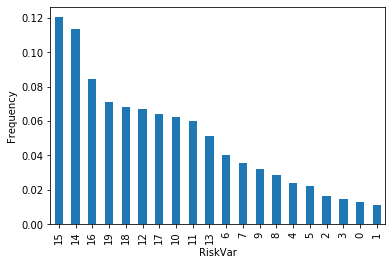

In [0]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [0]:
FreqCount

,Count,Freq
RiskVar,,
15,4906,0.120446
14,4625,0.113547
16,3444,0.084553
19,2894,0.071050
18,2773,0.068079
12,2719,0.066753
17,2614,0.064176
10,2533,0.062187
11,2445,0.060027


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [0]:
df['weight'] = np.where(df['RiskVar'].isin([14, 15]), 0.5, 1)

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [0]:
X = df.drop(columns=['Exposure', 'RiskVar'])
y = df['RiskVar']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=21)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [0]:
xgb_train = xgb.DMatrix(x_train.drop(columns=['weight']).values,
                        y_train.values,
                        weight=x_train['weight'].values)

xgb_valid = xgb.DMatrix(x_valid.drop(columns=['weight']).values,
                        y_valid.values)

xgb_test = xgb.DMatrix(x_test.drop(columns=['weight']).values,
                       y_test.values)

Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [0]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': y.nunique()
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']),
                       nfold=3, metrics=['merror'], # Exact matching error, used to evaluate multi-class classification
                       seed=21, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0]
    return score

In [0]:
# Определим границы, в которых будем искать гиперпараметры 

space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1)
        }

In [0]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

100%|██████████| 10/10 [1:46:31<00:00, 690.17s/it, best loss: 0.818347]


In [0]:
# Оптимальные гиперпараметры 

best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['eval_metric'] = 'merror'
best_params['num_boost_round'] = int(best_params['num_boost_round'])
best_params['num_class'] = y.nunique()
best_params

{'alpha': 0.6125632114337183,
 'colsample_bytree': 0.9212023794611051,
 'eta': 0.5010620669783736,
 'eval_metric': 'merror',
 'lambda': 0.80743908683425,
 'max_depth': 12,
 'min_child_weight': 43.08364755619517,
 'num_boost_round': 239,
 'num_class': 20,
 'objective': 'multi:softmax',
 'subsample': 0.9473435306933524}

Далее обучим нашу модель с оптимальными параметрами

In [0]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_riskvar = xgb.train(params=best_params, dtrain=xgb_train,
                        maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")],
                        early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [0]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_riskvar.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score
    print('Accuracy on ' + str(dfset['set'])+':', accuracy_score(dfset['target'], class_preds)) # Посчитаем accuracy
    print('')

F1 Score on train: 0.22762345679012347
Accuracy on train: 0.22762345679012347

F1 Score on valid: 0.1469721767594108
Accuracy on valid: 0.1469721767594108

F1 Score on test: 0.14435351882160394
Accuracy on test: 0.14435351882160394



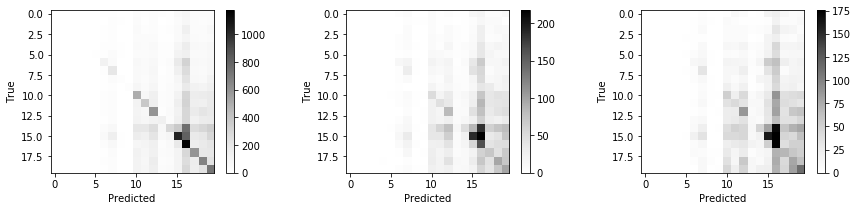

In [0]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_riskvar.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

In [0]:
**Качество модели в данном случае вышло невысоким - даже на обучающей выборке, судя по метрикам и более четкой визуализации матрицы ошибок (чуть более высокое качество объяснимо переобучением модели). По визуализации матрицы ошибок также видно, что не удалось до конца решить проблему дисбаланса классов, поскольку самые распространенные классы с метками 15 и 16 определяются лучше всего, и необходимо применить другой вариант решения этой проблемы.**

**Для улучшения качества:**
 - Расширить множество параметров для подбора. Стоит рассмотрето и более сложные варианты моделей.
 - Провести статистический анализ данных. Синтезировать новые признаки, проверить корреляцию признакового пространства с целевой переменной, выделить значимые и полезные признаки.
 - Уменьшить количество классов с 20. Проверить, не стоит ли объединить некоторые значения показателя. Уже на данный момент исходя из визуализации матрицы ошибок можно предположить, что поскольку показатели ниже 10 классифицируются хуже, их стоит рассматреть под одной меткой класса.